In [17]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("/content/water-quality-1.csv")

# Convert American-style timestamps to datetime (ignore hour/min)
df['Collect DateTime'] = pd.to_datetime(
    df['Collect DateTime'],
    format='%m/%d/%Y %I:%M:%S %p',
    errors='coerce'
).dt.date

In [4]:
# Derive temporal features
df['Year'] = pd.to_datetime(df['Collect DateTime']).dt.year
df['Month'] = pd.to_datetime(df['Collect DateTime']).dt.month

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['Season'] = df['Month'].apply(get_season)

In [6]:
#Keep only relevant WQI parameters
relevant_params = [
    "pH  Field", "Temperature", "Dissolved Oxygen  Field", "Conductivity  Field",
    "Total Nitrogen", "Total Phosphorus"
]

df_filtered = df[df["Parameter"].isin(relevant_params)].copy()

print("Filtered dataset shape:", df_filtered.shape)
print("Unique parameters kept:", df_filtered["Parameter"].unique())

Filtered dataset shape: (407902, 28)
Unique parameters kept: ['Total Phosphorus' 'Temperature' 'Conductivity  Field' 'Total Nitrogen'
 'Dissolved Oxygen  Field' 'pH  Field']


In [7]:
df_wide = df_filtered.pivot_table(
    index=['Sample ID', 'Collect DateTime', 'Year', 'Month', 'Season'],
    columns='Parameter',
    values='Value',
    aggfunc='mean'
).reset_index()

#Simplify column names
df_wide.columns.name = None
df_wide.columns = [str(c).strip().replace("  ", " ") for c in df_wide.columns]

print("Wide dataset shape:", df_wide.shape)
print("Columns:", df_wide.columns.tolist())

Wide dataset shape: (137794, 11)
Columns: ['Sample ID', 'Collect DateTime', 'Year', 'Month', 'Season', 'Conductivity Field', 'Dissolved Oxygen Field', 'Temperature', 'Total Nitrogen', 'Total Phosphorus', 'pH Field']


In [8]:
cols_rename = {
    "pH Field": "pH",
    "Dissolved Oxygen Field": "DO",
    "Conductivity Field": "Conductivity",
    "Total Nitrogen": "Total_N",
    "Total Phosphorus": "Total_P",
}

df_small = df_wide.rename(columns=cols_rename).copy()

#Reorder columns neatly
df_small = df_small[[
    'pH', 'DO', 'Conductivity', 'Temperature', 'Total_N',
    'Total_P', 'Year', 'Month', 'Season'
]]

print(df_small.head())
print(df_small.shape)

   pH  DO  Conductivity  Temperature  Total_N  Total_P  Year  Month  Season
0 NaN NaN           NaN         17.1      NaN      NaN  2015      8  Summer
1 NaN NaN           NaN         18.7      NaN      NaN  2015      8  Summer
2 NaN NaN           NaN          NaN    0.497      NaN  2015      8  Summer
3 NaN NaN           NaN         15.9    0.299      NaN  2015      8  Summer
4 NaN NaN           NaN         15.2      NaN      NaN  2015      8  Summer
(137794, 9)


In [9]:
# Missingness summary
missing_info = pd.DataFrame({
    "Missing Count": df_small.isna().sum(),
    "Missing %": (df_small.isna().sum() / len(df_small) * 100).round(2)
}).sort_values(by="Missing %", ascending=False)

print(missing_info)

              Missing Count  Missing %
Total_N              102424      74.33
Total_P               87725      63.66
Conductivity          67538      49.01
DO                    66536      48.29
pH                    56647      41.11
Temperature           40625      29.48
Year                      0       0.00
Month                     0       0.00
Season                    0       0.00


In [10]:
#Outlier removal
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

In [27]:
numeric_cols = ['Temperature', 'pH', 'DO', 'Conductivity',
                'Total_N', 'Total_P']

for col in numeric_cols:
    df_small = remove_outliers_iqr(df_small, col)

In [28]:
numeric_cols = ['Temperature', 'pH', 'DO', 'Conductivity',
                'Total_N', 'Total_P',]

# Apply KNN imputation
imputer = KNNImputer(n_neighbors=5)
df_small[numeric_cols] = imputer.fit_transform(df_small[numeric_cols])

#PRE-1990 TEMPERTURE SPIKE
year_counts = df_small['Year'].value_counts().sort_index()
print(year_counts)

Year
1993     39
1994     99
1995    148
1996    225
1997    168
1998    171
1999    188
2000    181
2001    166
2002    159
2003    116
2004     64
2005     14
2006      6
2007      8
2008      4
2009      3
2010      6
2011      9
2012      7
2013     11
2014      6
2015      9
2016     12
2017     10
2018     12
2019      8
Name: count, dtype: int64


In [29]:
missing_info = pd.DataFrame({
    "Missing Count": df_small.isna().sum(),
    "Missing %": (df_small.isna().sum() / len(df_small) * 100).round(2)
}).sort_values(by="Missing %", ascending=False)

print(missing_info)

              Missing Count  Missing %
pH                        0        0.0
DO                        0        0.0
Conductivity              0        0.0
Temperature               0        0.0
Total_N                   0        0.0
Total_P                   0        0.0
Year                      0        0.0
Month                     0        0.0
Season                    0        0.0


      count       mean       std   min     25%     50%     75%   max
Year                                                                
1993   40.0  13.422750  4.620519  6.26  8.8950  14.600  17.400  22.6
1994  109.0  11.751101  4.951648  6.30  7.6800   9.030  15.700  23.5
1995  164.0  10.764573  4.601947  6.33  7.5375   9.015  11.325  22.2


<Axes: title={'center': 'Yearly Median Temperature'}, xlabel='Year'>

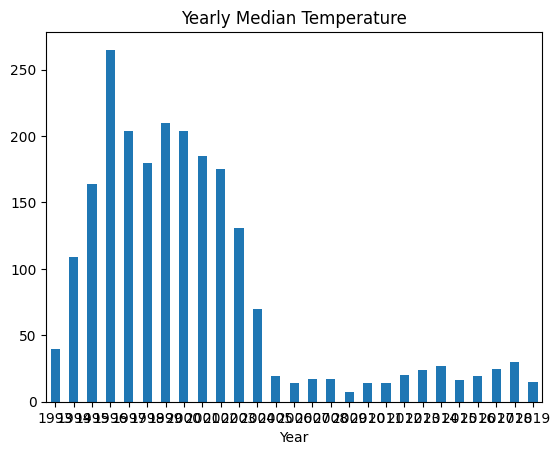

In [26]:
#Visualise data availability
year_counts.plot(kind='bar', title='Sample Count by Year')

#Check descriptive stats for Temperature by year
yearly_stats = df_small.groupby('Year')['Temperature'].describe()
print(yearly_stats.loc[1980:1995])  # focus on period of interest

#Quick visual of the spike
df_small.groupby('Year')['Temperature'].median().plot(title='Yearly Median Temperature')

In [22]:
def plot_boxplot(df, ft):
    df.boxplot(column=[ft])
    plt.grid(False)
    plt.show()
    #checking outliers

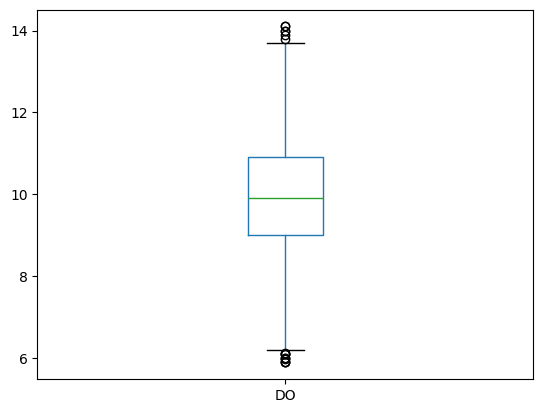

In [30]:
plot_boxplot(df_small, 'DO')

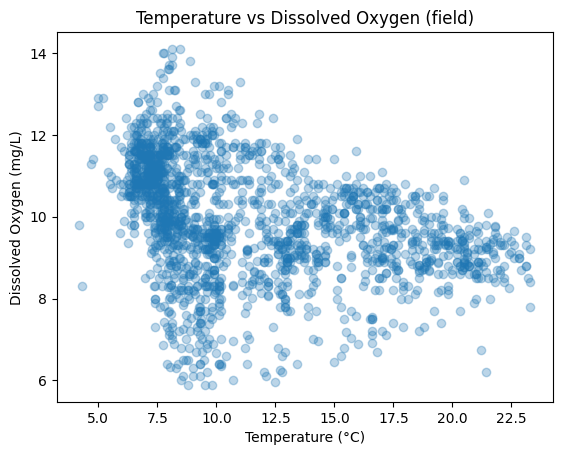

In [33]:
plt.scatter(df_small["Temperature"], df_small["DO"], alpha=0.3)
plt.title("Temperature vs Dissolved Oxygen (field)")
plt.xlabel("Temperature (°C)")
plt.ylabel("Dissolved Oxygen (mg/L)")
plt.show()

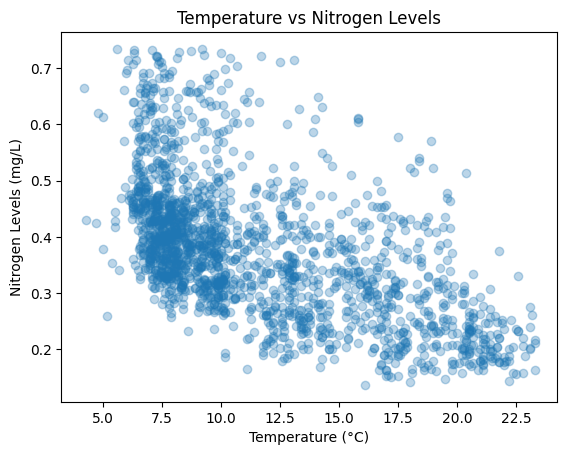

In [35]:
plt.scatter(df_small["Temperature"], df_small["Total_N"], alpha=0.3)
plt.title("Temperature vs Nitrogen Levels")
plt.xlabel("Temperature (°C)")
plt.ylabel("Nitrogen Levels (mg/L)")
plt.show()

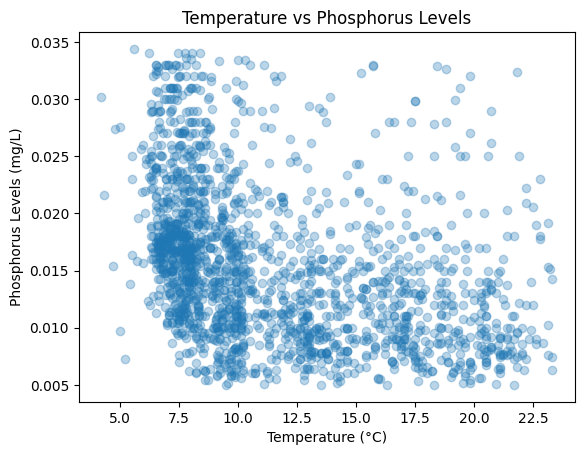

In [37]:
plt.scatter(df_small["Temperature"], df_small["Total_P"], alpha=0.3)
plt.title("Temperature vs Phosphorus Levels")
plt.xlabel("Temperature (°C)")
plt.ylabel("Phosphorus Levels (mg/L)")
plt.show()

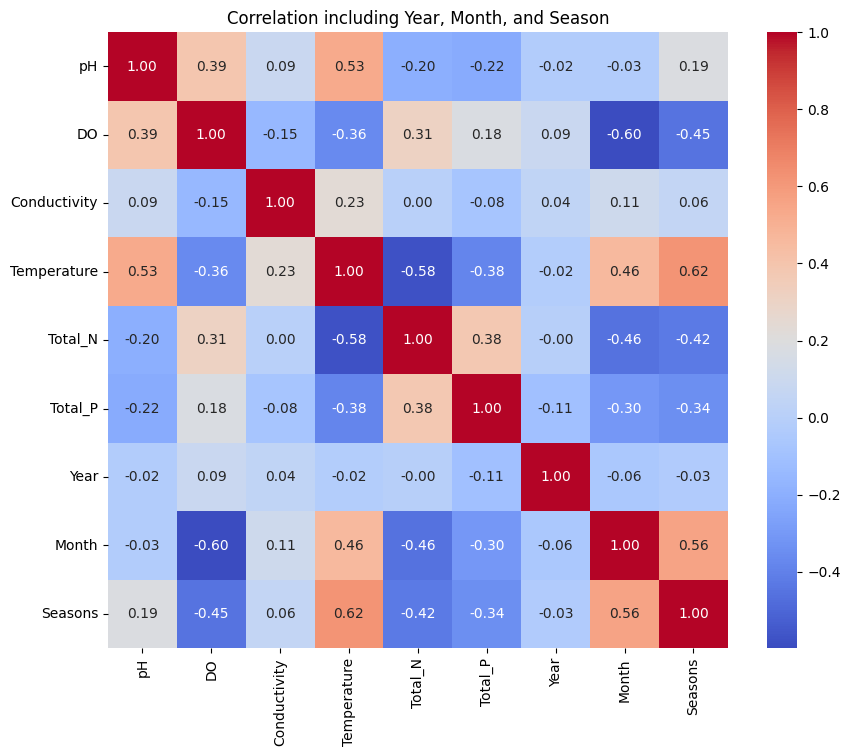

In [46]:
df_small['Seasons'] = df_small['Season'].map({
    'Winter': 1,
    'Spring': 2,
    'Summer': 3,
    'Autumn': 4
})

# Select columns for correlation
cols_for_corr = [
    'pH', 'DO', 'Conductivity', 'Temperature',
    'Total_N', 'Total_P',
    'Year', 'Month', 'Seasons'
]

plt.figure(figsize=(10,8))
sns.heatmap(df_small[cols_for_corr].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation including Year, Month, and Season")
plt.show()
#year month and season were not numeric values so had to be encoded

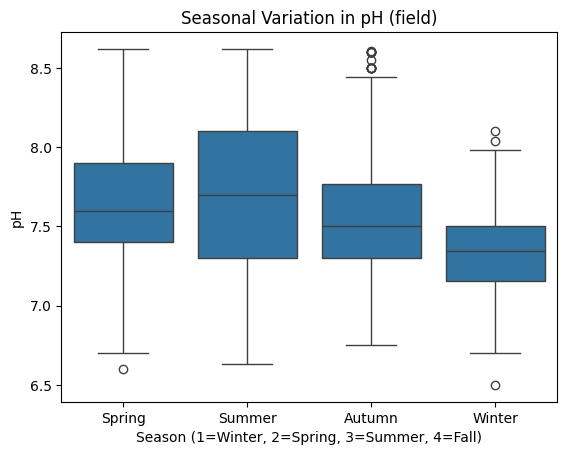

In [51]:
sns.boxplot(x="Season", y="pH", data=df_small)
plt.title("Seasonal Variation in pH (field)")
plt.xlabel("Season (1=Winter, 2=Spring, 3=Summer, 4=Fall)")
plt.ylabel("pH")
plt.show()

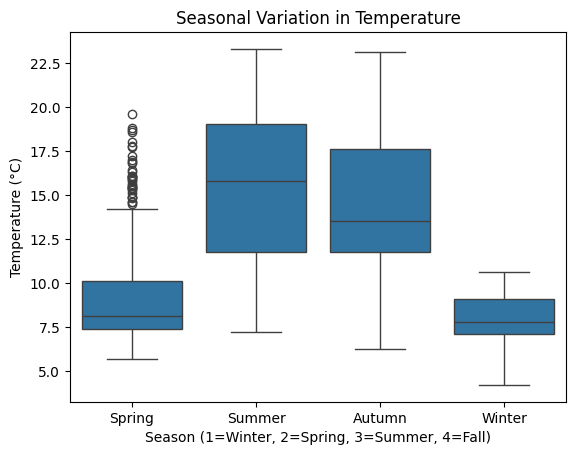

In [50]:
sns.boxplot(x="Season", y="Temperature", data=df_small)
plt.title("Seasonal Variation in Temperature")
plt.xlabel("Season (1=Winter, 2=Spring, 3=Summer, 4=Fall)")
plt.ylabel("Temperature (°C)")
plt.show()

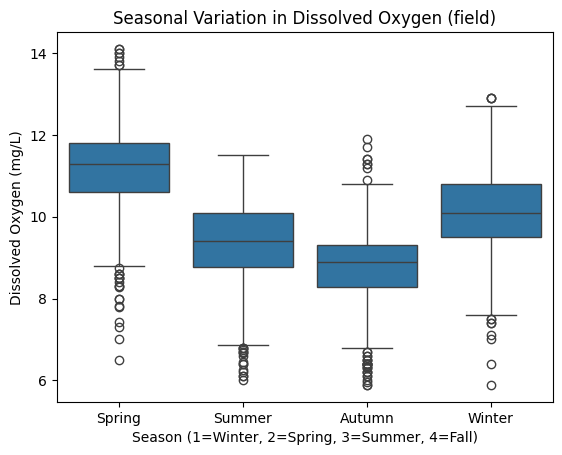

In [53]:
sns.boxplot(x="Season", y="DO", data=df_small)
plt.title("Seasonal Variation in Dissolved Oxygen (field)")
plt.xlabel("Season (1=Winter, 2=Spring, 3=Summer, 4=Fall)")
plt.ylabel("Dissolved Oxygen (mg/L)")
plt.show()

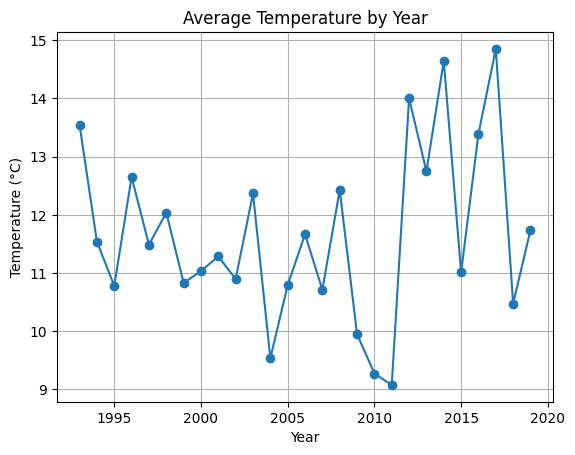

In [42]:
yearly_temp = df_small.groupby("Year")["Temperature"].mean()

plt.plot(yearly_temp.index, yearly_temp.values, marker="o")
plt.title("Average Temperature by Year")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.show()

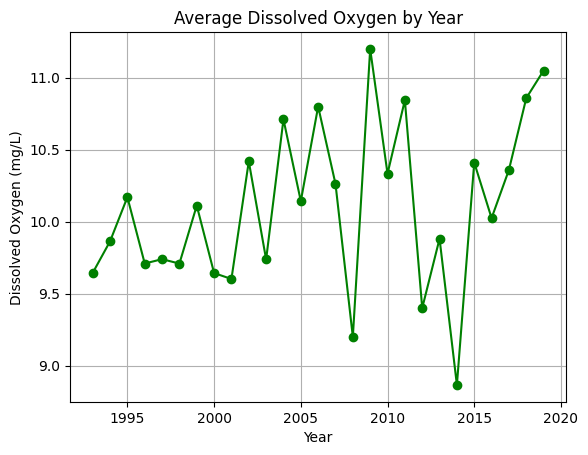

In [54]:
yearly_do = df_small.groupby("Year")["DO"].mean()

plt.plot(yearly_do.index, yearly_do.values, marker="o", color="green")
plt.title("Average Dissolved Oxygen by Year")
plt.xlabel("Year")
plt.ylabel("Dissolved Oxygen (mg/L)")
plt.grid(True)
plt.show()


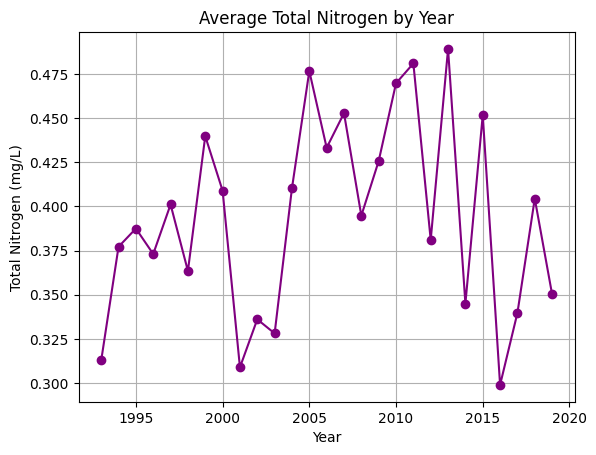

In [57]:
yearly_do = df_small.groupby("Year")["Total_N"].mean()

plt.plot(yearly_do.index, yearly_do.values, marker="o", color="purple")
plt.title("Average Total Nitrogen by Year")
plt.xlabel("Year")
plt.ylabel("Total Nitrogen (mg/L)")
plt.grid(True)
plt.show()


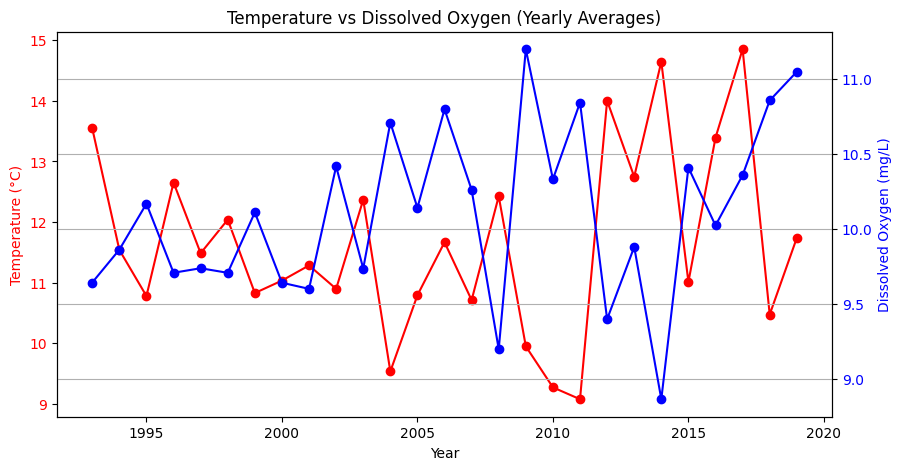

In [55]:
yearly = df_small.groupby("Year")[["Temperature", "DO"]].mean()

fig, ax1 = plt.subplots(figsize=(10,5))

# Temperature (left axis)
ax1.plot(yearly.index, yearly["Temperature"], color="red", marker="o", label="Temperature (°C)")
ax1.set_xlabel("Year")
ax1.set_ylabel("Temperature (°C)", color="red")
ax1.tick_params(axis="y", labelcolor="red")

# Dissolved Oxygen (right axis)
ax2 = ax1.twinx()
ax2.plot(yearly.index, yearly["DO"], color="blue", marker="o", label="Dissolved Oxygen (mg/L)")
ax2.set_ylabel("Dissolved Oxygen (mg/L)", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

plt.title("Temperature vs Dissolved Oxygen (Yearly Averages)")
plt.grid(True)
plt.show()

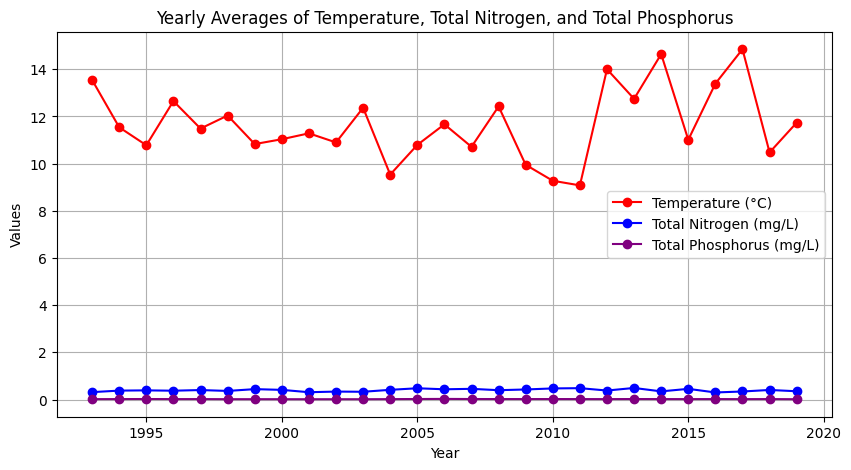

In [56]:
yearly = df_small.groupby("Year")[["Temperature", "Total_N", "Total_P"]].mean()

plt.figure(figsize=(10,5))
plt.plot(yearly.index, yearly["Temperature"], marker="o", label="Temperature (°C)", color="red")
plt.plot(yearly.index, yearly["Total_N"], marker="o", label="Total Nitrogen (mg/L)", color="blue")
plt.plot(yearly.index, yearly["Total_P"], marker="o", label="Total Phosphorus (mg/L)", color="purple")

plt.title("Yearly Averages of Temperature, Total Nitrogen, and Total Phosphorus")
plt.xlabel("Year")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.show()

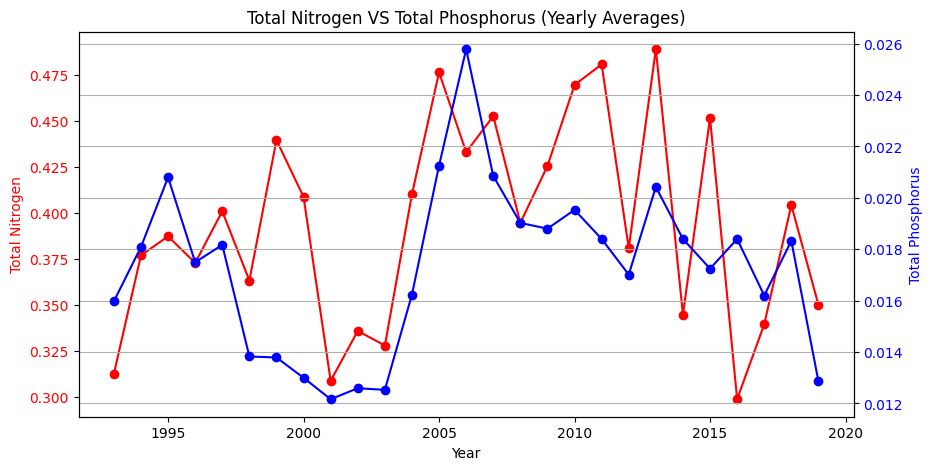

In [58]:
yearly = df_small.groupby("Year")[["Total_N", "Total_P"]].mean()

fig, ax1 = plt.subplots(figsize=(10,5))

# Nitrogen (left axis)
ax1.plot(yearly.index, yearly["Total_N"], color="red", marker="o", label="Total Nitrogen")
ax1.set_xlabel("Year")
ax1.set_ylabel("Total Nitrogen", color="red")
ax1.tick_params(axis="y", labelcolor="red")

# Phosphorus (right axis)
ax2 = ax1.twinx()
ax2.plot(yearly.index, yearly["Total_P"], color="blue", marker="o", label="Total Phosphorus")
ax2.set_ylabel("Total Phosphorus", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

plt.title("Total Nitrogen VS Total Phosphorus (Yearly Averages)")
plt.grid(True)
plt.show()

In [59]:
#MLR analysis
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson

In [69]:
target = 'Temperature'
predictors = [
    'pH', 'DO', 'Conductivity',
    'Total_N', 'Total_P']


In [70]:
X = sm.add_constant(df_small[predictors])
y = df_small[target]
mlr = sm.OLS(y, X).fit()
print(mlr.summary())

                            OLS Regression Results                            
Dep. Variable:            Temperature   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     965.7
Date:                Sun, 12 Oct 2025   Prob (F-statistic):               0.00
Time:                        20:55:51   Log-Likelihood:                -4235.1
No. Observations:                1849   AIC:                             8482.
Df Residuals:                    1843   BIC:                             8515.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -27.6570      1.283    -21.553   

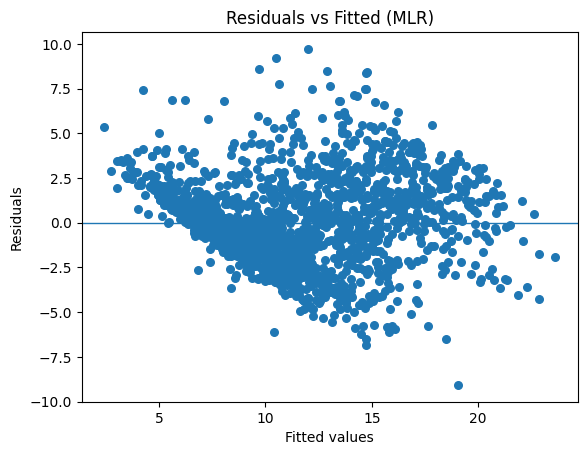

In [71]:
#residuals
fitted = mlr.fittedvalues
resid = mlr.resid

plt.figure()
plt.scatter(fitted, resid, s=30)
plt.axhline(0, linewidth=1)
plt.xlabel("Fitted values"); plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (MLR)"); plt.show()

In [72]:
#VIF
X_vif = df_small[predictors].values
vif_vals = [variance_inflation_factor(X_vif, i) for i in range(X_vif.shape[1])]
pd.DataFrame({"predictor": predictors, "VIF": np.round(vif_vals, 2)})

,predictor,VIF
0,pH,232.42
1,DO,77.45
2,Conductivity,139.09
3,Total_N,14.27
4,Total_P,7.43


from matplotlib import pyplot as plt
_df_0['VIF'].plot(kind='hist', bins=20, title='VIF')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('predictor').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['VIF'].plot(kind='line', figsize=(8, 4), title='VIF')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_3['predictor'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_3, x='VIF', y='predictor', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)